<a href="https://colab.research.google.com/github/zhus-dika/togyz-qumalaq-agent/blob/main/togyzqumalaq_aec_vs_random_policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🦛 Install need packages

In [1]:
#!python -m ipykernel install --user --name=venv

### 🐞 Imports

In [20]:
import gymnasium
import os
import numpy as np
from gymnasium.spaces import Discrete, MultiDiscrete
from gymnasium import spaces

from IPython.display import clear_output
import time
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import csv
import pandas as pd
from scipy.interpolate import interp1d

import os
from typing import Optional, Tuple

from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger

import gymnasium
import numpy as np
import torch
from copy import deepcopy
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import MultiAgentPolicyManager, RandomPolicy, BasePolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils.net.common import Net
from tianshou.policy import DiscreteSACPolicy
from tianshou.utils.net.discrete import Actor, Critic, IntrinsicCuriosityModule

import random
import copy

NUM_ITERS = 1000
PLAYS = {"bastaushy": 0, "qostaushy": 0}
REWARDS = {"bastaushy": [], "qostaushy": []}

### 🐯 Parameters

In [17]:
NET_ARCHS = [[256, 512, 256]]

MAX_EPOCHS = 3000

# step_per_epoch=1000,
# step_per_collect=50,
# episode_per_test=10,

STEP_PER_EPOCH = 1000

STEP_PER_COLLECT = 50 #50

EPISODE_PER_TEST = 10 #10

BATCH_SIZE = 256

MODELS_PATH = {}

MODELS_PATH['bastaushy'] = os.path.join('..', 'models', 'sac', 'zero-sum', 'bastaushy')

MODELS_PATH['qostaushy'] = os.path.join('..', 'models', 'sac', 'zero-sum', 'qostaushy')

LOGS_PATH = {}

LOGS_PATH['bastaushy'] = os.path.join('..', 'logs', 'sac', 'zero-sum', 'bastaushy')

LOGS_PATH['qostaushy'] = os.path.join('..', 'logs', 'sac', 'zero-sum', 'qostaushy')

#  🐘 AEC environment https://pettingzoo.farama.org/api/aec/#about-aec

### 🦉 Create environment

In [3]:
def env(render_mode=None):
    """
    The env function often wraps the environment in wrappers by default.
    You can find full documentation for these methods
    elsewhere in the developer documentation.
    """
    internal_render_mode = render_mode if render_mode != "ansi" else "human"
    env = raw_env(render_mode=internal_render_mode)
    # This wrapper is only for environments which print results to the terminal
    if render_mode == "ansi":
        env = wrappers.CaptureStdoutWrapper(env)
    # this wrapper helps error handling for discrete action spaces
    env = wrappers.AssertOutOfBoundsWrapper(env)
    # Provides a wide vareity of helpful user errors
    # Strongly recommended
    env = wrappers.OrderEnforcingWrapper(env)
    return env


class raw_env(AECEnv):
    """
    The metadata holds environment constants. From gymnasium, we inherit the "render_modes",
    metadata which specifies which modes can be put into the render() method.
    At least human mode should be supported.
    The "name" metadata allows the environment to be pretty printed.
    """

    metadata = {
        "render_modes": ["ansi", "human"],
        "name": "togyzqumalaq_v0"
        }

    def __init__(self, render_mode=None):
        """
        The init method takes in environment arguments and
         should define the following attributes:
        - otaular
        - tuzdyq
        - qazandar
        - possible_agents
        - render_mode

        Note: as of v1.18.1, the action_spaces and observation_spaces attributes are deprecated.
        Spaces should be defined in the action_space() and observation_space() methods.
        If these methods are not overridden, spaces will be inferred from self.observation_spaces/action_spaces, raising a warning.

        These attributes should not be changed after initialization.
        """
        self.otaular = []
        self.tuzdyq = []
        self.qazandar = []
        self.direction = []
        self.agents = ["bastaushy", "qostaushy"]
        self.possible_agents = self.agents[:]
        # optional: we can define the observation and action spaces here as attributes to be used in their corresponding methods
        self.action_spaces = {i: spaces.Discrete(9) for i in self.agents}
        self.observation_spaces = {
            i: spaces.Dict(
                {
                    "observation": MultiDiscrete([100] * 18 + [9] * 2 + [82] * 2),
                    "action_mask": Discrete(9),
                }
            )
            for i in self.agents
        }
        self.render_mode = render_mode

    # Observation space should be defined here.
    def action_space(self, agent):
        return self.action_spaces[agent]

    # Action space should be defined here.
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def render(self):
        """
        Renders the environment. In human mode,
        it can print to terminal, open
        up a graphical window, or open up some
        other display that
        a human can see and understand.
        """
        """Renders the environment."""
        if self.render_mode is None:
            gymnasium.logger.warn(
                "You are calling render method without "
                "specifying any render mode."
            )
            return

        if len(self.agents) == 2:
            points_bastaushy_x = np.array([i * 2 for i in range(10)])
            points_bastaushy_y = np.array([i % 5 for i in range(50)])

            x = np.arange(-3, 225, 1)
            y = -1

            text_kwargs = dict(ha='center', va='center', fontsize=12)
            plt.figure(figsize=(17, 6))

            for i in range(9):
                # qostaushy's part
                plt.scatter(
                    np.repeat(points_bastaushy_x + 25 * i, 5)[:self.otaular[17 - i]], points_bastaushy_y[:self.otaular[17 - i]], marker='o')
                # horizontal line
                plt.plot(x, np.repeat(y, len(x)))
                # vertical lines
                plt.plot(np.repeat(25 * i - 2, len(x)), np.arange(-7, 5, 12 / len(x)))
                # bastaushy's part
                plt.scatter(np.repeat(points_bastaushy_x + 25 * i, 5)[:self.otaular[i]],
                            points_bastaushy_y[:self.otaular[i]] - 6, marker='o')

            # last vertical line
            plt.plot(np.repeat(25 * 9 - 2, len(x)), np.arange(-7, 5, 12 / len(x)))

            for i in range(9):
                # bastaushy's qumalaqtar
                plt.text(25 * i + 10, -7,
                         f'{i} ({self.otaular[i]})', **text_kwargs)
                # qostaushy's qumalaqtar
                plt.text(25 * i + 10, 5,
                         f'{17 - i} ({self.otaular[17 - i]})', **text_kwargs)
            # bastaushy qazan's qumalaqtar
            plt.text(230, -4,
                     f'qazan: {self.qazandar[0]}', **text_kwargs)
            # qostaushy qazan's qumalaqtar
            plt.text(230, 2,
                     f'qazan: {self.qazandar[1]}', **text_kwargs)
            # bastaushy tuzdyq's qumalaqtar
            plt.text(230, -6,
                     f'tuzdyq: {self.tuzdyq[0]}', **text_kwargs)
            # qostaushy tuzdyq's qumalaqtar
            plt.text(230, 0,
                     f'tuzdyq: {self.tuzdyq[1]}', **text_kwargs)
            plt.xticks([])
            plt.yticks([])
            plt.show()
        else:
            if self.render_mode == "human":
                print("Game over")
        
        time.sleep(1)
        clear_output(True)

    def _legal_moves(self, agent):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2
        return [item for item in range(9 * cur_player, (cur_player + 1) * 9) if self.tuzdyq[opp_player] != item and self.otaular[item] > 0]

    def observe(self, agent):
        """
        Observe should return the observation of the specified agent. This function
        should return a sane observation (though not necessarily the most up to date possible)
        at any time after reset() is called.
        """
        # observation of one agent is the previous state of the other
        legal_moves = self._legal_moves(agent) if agent == self.agent_selection else []
        action_mask = np.zeros(9, "int8")
        if self.possible_agents.index(agent) == 1:
            legal_moves = [i - 9 for i in legal_moves]
        for i in legal_moves:
            action_mask[i] = 1
        observation = tuple(
            self.otaular + self.tuzdyq + self.qazandar
        )
        return {"observation": observation, "action_mask": action_mask}

    def close(self):
        """
        Close should release any graphical displays, subprocesses, network connections
        or any other environment data which should not be kept around after the
        user is no longer using the environment.
        """
        pass

    def reset(self, seed=None, options=None):
        """
        Reset needs to initialize the following attributes
        - agents
        - rewards
        - _cumulative_rewards
        - terminations
        - truncations
        - infos
        - agent_selection
        And must set up the environment so that render(), step(), and observe()
        can be called without issues.
        Here it sets up the state dictionary which is used by step() and the observations dictionary which is used by step() and observe()
        """
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.otaular = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
        self.direction = [list(range(18)), [9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8]]
        self.tuzdyq = [-1, -1]
        self.qazandar = [0, 0]
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.num_moves = 0
        observation = tuple(
            self.otaular + self.tuzdyq + self.qazandar
        )
        self.observations = {agent: observation for agent in self.agents}
        """
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        """
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()

    def step(self, action):
        """
        step(action) takes in an action for the current agent (specified by
        agent_selection) and needs to update
        - rewards
        - _cumulative_rewards (accumulating the rewards)
        - terminations
        - truncations
        - infos
        - agent_selection (to the next agent)
        And any internal state used by observe() or render()
        """
        if (
            self.terminations[self.agent_selection]
            or self.truncations[self.agent_selection]
        ):
            # handles stepping an agent which is already dead
            # accepts a None action for the one agent, and moves the agent_selection to
            # the next dead agent,  or if there are no more dead agents, to the next live agent
            self._was_dead_step(action)
            return

        cur_player = self.possible_agents.index(self.agent_selection)
        opp_player = (cur_player + 1) % 2

        self.num_moves += 1
        if self.render_mode == "human":
            print(f'MOVE #{self.num_moves}')
        # The truncations dictionary must be updated for all players.
        self.truncations = {
            agent: self.num_moves >= NUM_ITERS for agent in self.agents
        }
        # distribute qumalaqs
        if cur_player == 1:
            action += 9
        # if self.render_mode == "human":
        #     print(f'{self.agent_selection} made action {action}')
        num_qumalaq = self.otaular[action]
        idx_action = self.direction[cur_player].index(action)
        if self.otaular[action] == 1:
            self.otaular[self.direction[cur_player][idx_action + 1]] += 1
            
            #=======================================================================#
            # curriculum lesson # 7
            # if self.direction[cur_player][idx_action + 1] in range(opp_player * 9, (opp_player + 1) * 9):
            #     self.rewards[self.agent_selection] -= 1
            #     self.rewards[self.possible_agents[opp_player]] += 1
            #=======================================================================#
            
            self.otaular[action] -= 1
        else:
            i = 1
            while self.otaular[action] > 1:
                self.otaular[self.direction[cur_player][(idx_action + i) % 18]] += 1
                #=======================================================================#
                # curriculum lesson # 7
                # if self.direction[cur_player][(idx_action + i) % 18] in range(opp_player * 9, (opp_player + 1) * 9):
                #     self.rewards[self.agent_selection] -= 1
                #     self.rewards[self.possible_agents[opp_player]] += 1
                #=======================================================================#
                self.otaular[action] -= 1
                i += 1
        # check tuzdyq & add rewards to qazandar
        reward = 0
        
        if self.check_tuzdyq(self.agent_selection, action):
            reward += 3
            #=======================================================================#
            # curriculum lesson # 6
            # increase reward for winning tuzdyq
            # self.rewards[self.agent_selection] += 50
            # self.rewards[self.possible_agents[opp_player]] -= 50
            #=======================================================================#
            # if self.render_mode == "human":
            #     print(f'{self.agent_selection} won tuzdyq {reward}')
        else:

            if num_qumalaq > 1:
                last_otau = self.direction[cur_player][(idx_action + num_qumalaq - 1) % 18]
            else:
                last_otau = self.direction[cur_player][(idx_action + num_qumalaq) % 18]

            if last_otau in range(opp_player * 9, (opp_player + 1) * 9) and self.otaular[last_otau] % 2 == 0:
                reward += self.otaular[last_otau]
                # if self.render_mode == "human":
                #     print(f'{self.agent_selection} won {reward}')
                self.otaular[last_otau] = 0
            if self.tuzdyq[cur_player] >= 0 and self.otaular[self.tuzdyq[cur_player]] > 0:
                reward += self.otaular[self.tuzdyq[cur_player]]
                # if self.render_mode == "human":
                #     print(f'{self.agent_selection} won tuzdyq {self.otaular[self.tuzdyq[cur_player]]}')
                self.otaular[self.tuzdyq[cur_player]] = 0
        # if self.render_mode == "human":
        #     print(f'{self.agent_selection} won total {reward}')
        self.qazandar[cur_player] += reward
        #=======================================================================#
        # curriculum lesson # 1
        # for i in range(cur_player * 9, 9 + cur_player * 9):
        #     if self.otaular[i] % 2 != 0:
        #         reward -= 1
        
        #=======================================================================#
        # curriculum lesson # 2
        opp_actions = self._legal_moves(self.possible_agents[opp_player])
        rew_opp = 0
        for opp_act in opp_actions:
            num_qumalaq = self.otaular[opp_act]
            idx_action = self.direction[opp_player].index(action)
            if num_qumalaq > 1:
                last_otau = self.direction[opp_player][(idx_action + num_qumalaq - 1) % 18]
            else:
                last_otau = self.direction[opp_player][(idx_action + num_qumalaq) % 18]
            if rew_opp < self.otaular[last_otau] and self.otaular[last_otau] % 2 == 1 and last_otau in range(cur_player * 9, (cur_player + 1) * 9):
                rew_opp = self.otaular[last_otau]
        self.rewards[self.agent_selection] -= rew_opp
        #=======================================================================#
        # curriculum lesson # 3
        # reduce the number of steps
        # self.rewards[self.agent_selection] -= 1

        # check opponent's atsyrau
        if self.check_atsyrau(self.possible_agents[opp_player]) and self.qazandar[opp_player] <= 81:
            for i in range(9):
                self.qazandar[cur_player] += self.otaular[i + cur_player * 9]
                reward += self.otaular[i + cur_player * 9]

        self.rewards[self.agent_selection] += reward
        # self.rewards[self.possible_agents[opp_player]] -= reward
        REWARDS[self.agent_selection].append(self.qazandar[cur_player])
        # check if there is a winner
        winner = self.check_for_winner()

        #=======================================================================#
        # curriculum lesson # 4
        # increase reward for winning the game

        #=======================================================================#
        # curriculum lesson # 5
        # calculate reward in other way
        # self.rewards[self.agent_selection] += (self.qazandar[cur_player] - self.qazandar[opp_player]) / 82
        # self.rewards[self.agent_selection] -= 0.05
        if winner:
            # print("NSTEPS =", self.num_moves)
            self.rewards[self.agent_selection] += 500
            # self.rewards[self.possible_agents[opp_player]] -= 500
            # self.rewards[self.agent_selection] += 1
            self.terminations = {i: True for i in self.agents}
            # if self.render_mode == "human":
            #     print(f'{self.agent_selection} won the game!!!')
        # selects the next agent.
        self.agent_selection = self._agent_selector.next()
        # Adds .rewards to ._cumulative_rewards
        self._accumulate_rewards()

        if self.render_mode == "human":
            self.render()

    def check_tuzdyq(self, agent, action):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2
        idx = self.direction[cur_player].index(action)
        num_qumalaq = self.otaular[action]

        if num_qumalaq > 1:
            last_otau = self.direction[cur_player][(idx + num_qumalaq - 1) % 18]
        else:
            last_otau = self.direction[cur_player][(idx + num_qumalaq) % 18]

        if last_otau in range(opp_player * 9, (opp_player + 1) * 9) and self.otaular[last_otau] == 3 and last_otau != 17 - cur_player * 9 and abs(last_otau - self.tuzdyq[opp_player]) != 9:
            self.tuzdyq[cur_player] = last_otau
            self.otaular[last_otau] = 0
            # if self.render_mode == "human":
            #     print(f'{agent} got tuzdyq {last_otau}!')
            return True

        return False

    def check_atsyrau(self, agent):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2

        for idx, i in enumerate(self.otaular[cur_player * 9: (cur_player + 1) * 9]):
            if i > 0 and idx + cur_player * 9 != self.tuzdyq[opp_player]:
                return False
        # if self.render_mode == "human":
        #     print(f'{agent} reached atsyrau')
        return True

    def check_for_winner(self):
        cur_player = self.possible_agents.index(self.agent_selection)
        opp_player = (cur_player + 1) % 2
        if self.qazandar[cur_player] > 81:
            PLAYS[self.agent_selection] += 1
            return True
        return False

### 🦚 Testing environment

In [6]:
# env = env(render_mode="human")
# env.reset(seed=42)

# for agent in env.agent_iter():
#     observation, reward, termination, truncation, info = env.last()

#     if termination or truncation:
#         action = None
#     else:
#         mask = observation["action_mask"]
#         # this is where you would insert your policy
#         action = env.action_space(agent).sample(mask)

#     env.step(action)
# env.close()

# 🐼 DQN agent to play vs a random policy agent https://pettingzoo.farama.org/tutorials/tianshou/intermediate/

### 🐫 Prepare main functions

In [18]:
def _get_agents_sac(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    agent_type = None,
    net_arch = [64, 128, 128, 64],
    device = "cuda" if torch.cuda.is_available() else "cpu"
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = _get_env()
    observation_space = (
        env.observation_space["observation"]
        if isinstance(env.observation_space, gymnasium.spaces.Dict)
        else env.observation_space
    )
    if agent_learn is None:
        # model
        net = Net(
            state_shape=observation_space.shape or observation_space.n,
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=net_arch
        ).to(device)
        
        actor = Actor(net, 9, device=device, softmax_output=False)
        actor_optim = torch.optim.Adam(actor.parameters(), lr=1e-5)
        critic1 = Critic(net, last_size=9, device=device)
        critic1_optim = torch.optim.Adam(critic1.parameters(), lr=1e-5)
        critic2 = Critic(net, last_size=9, device=device)
        critic2_optim = torch.optim.Adam(critic2.parameters(), lr=1e-5)

        agent_learn = DiscreteSACPolicy(
            actor=actor,
            actor_optim=actor_optim,
            critic=critic1,
            critic_optim=critic1_optim,
            critic2=critic2,
            critic2_optim=critic2_optim,
            action_space=env.action_space,
            tau=0.05,
            gamma=0.99,
            alpha=0.05,
            estimation_step=3,
        ).to(device)


    if agent_opponent is None:
        agent_opponent = RandomPolicy(action_space=env.action_space)
        
    if agent_type=="qostaushy":
        agents = [agent_opponent, agent_learn]
    else:
        agents = [agent_learn, agent_opponent]
    policy = MultiAgentPolicyManager(policies=agents, env=env)
    return policy, optim, env.agents


def _get_env(render_mode=None):
    """This function is needed to provide callables for DummyVectorEnv."""
    def env(render_mode=None):
        """
        The env function often wraps the environment in wrappers by default.
        You can find full documentation for these methods
        elsewhere in the developer documentation.
        """
        internal_render_mode = render_mode if render_mode != "ansi" else "human"
        env = raw_env(render_mode=internal_render_mode)
        # This wrapper is only for environments which print results to the terminal
        if render_mode == "ansi":
            env = wrappers.CaptureStdoutWrapper(env)
        # this wrapper helps error handling for discrete action spaces
        env = wrappers.AssertOutOfBoundsWrapper(env)
        # Provides a wide vareity of helpful user errors
        # Strongly recommended
        env = wrappers.OrderEnforcingWrapper(env)
        return env
    return PettingZooEnv(env(render_mode=render_mode))

### 🐦 Add logger (to run tensorboard type in terminal  $tensorboard --logdir logs/dqn)

In [84]:
log_path = os.path.join('..', 'logs', "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

# 🐎 Self-play training agents

### 🦚 Methods train agent

In [5]:
def train_agent_sac_bastaushy(index, net_arch, agent_learn=None, agent_opponent=None, path="bastaushy", seed=11):
    # Before evaluate this cell run the cell with env
    # ======== Step 1: Environment setup =========
    train_envs = DummyVectorEnv([_get_env for _ in range(100)])
    test_envs = DummyVectorEnv([_get_env for _ in range(100)])
    
    # seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)
    
    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents_sac(agent_learn=agent_learn, agent_opponent=agent_opponent, agent_type=path, net_arch=net_arch)
    
    # # ======== Step 3: Collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(100_000, len(train_envs)),
        exploration_noise=True,
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    log_path = os.path.join(LOGS_PATH[path], str(index))
    writer = SummaryWriter(log_path)
    logger = TensorboardLogger(writer)
    # policy.set_eps(1)
    
    # ======== Step 4: Callback functions setup =========
    def save_best_fn(policy):
        model_save_path = os.path.join(MODELS_PATH[path], f'policy_sac_{arch2str(net_arch)}_{index}.pth')
        os.makedirs(MODELS_PATH[path], exist_ok=True)
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= 55000
    
    # def train_fn(epoch, env_step):
    #     policy.policies[agents[0]].set_eps(0.1)
    
    # def test_fn(epoch, env_step):
    #     policy.policies[agents[0]].set_eps(0.05)
    
    def reward_metric(rews):
        return rews[:, 0]

    # ======== Step 5: Run the trainer =========
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=MAX_EPOCHS,
        step_per_epoch=STEP_PER_EPOCH,
        step_per_collect=STEP_PER_COLLECT,
        episode_per_test=EPISODE_PER_TEST,
        batch_size=BATCH_SIZE,
        # train_fn=train_fn,
        # test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        verbose=True,
        logger=logger
    ).run()
    
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[0]])")
    return policy.policies[agents[0]]

In [6]:
def train_agent_sac_qostaushy(index, net_arch, agent_learn=None, agent_opponent=None, path="qostaushy", seed=11):
    # Before evaluate this cell run the cell with env
    # ======== Step 1: Environment setup =========
    train_envs = DummyVectorEnv([_get_env for _ in range(100)])
    test_envs = DummyVectorEnv([_get_env for _ in range(100)])
    
    # seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)
    
    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents_sac(agent_learn=agent_learn, agent_opponent=agent_opponent, agent_type=path, net_arch=net_arch)
    
    # # ======== Step 3: Collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(100_000, len(train_envs)),
        exploration_noise=True,
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    log_path = os.path.join(LOGS_PATH[path], str(index))
    writer = SummaryWriter(log_path)
    logger = TensorboardLogger(writer)
    # policy.set_eps(1)
    
    # ======== Step 4: Callback functions setup =========
    def save_best_fn(policy):
        model_save_path = os.path.join(MODELS_PATH[path], f'policy_sac_{arch2str(net_arch)}_{index}.pth')
        os.makedirs(MODELS_PATH[path], exist_ok=True)
        torch.save(policy.policies[agents[1]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= 55000
    
    # def train_fn(epoch, env_step):
    #     policy.policies[agents[1]].set_eps(0.1)
    
    # def test_fn(epoch, env_step):
    #     policy.policies[agents[1]].set_eps(0.05)
    
    def reward_metric(rews):
        return rews[:, 1]

    # ======== Step 5: Run the trainer =========
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=MAX_EPOCHS,
        step_per_epoch=STEP_PER_EPOCH,
        step_per_collect=STEP_PER_COLLECT,
        episode_per_test=EPISODE_PER_TEST,
        batch_size=BATCH_SIZE,
        # train_fn=train_fn,
        # test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        verbose=True,
        logger=logger
    ).run()
    
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[1]])")
    return policy.policies[agents[1]]

## 🐡 Train initial agents via random policy

### 🐜 Set net architectures 

In [7]:
def arch2str(net_arch):
    out = str(net_arch[0])
    for i in net_arch[1:]:
        out += 'x' + str(i)
    return out

def str2arch(inp):
    lst = inp.split('x')
    return [int(i) for i in lst]

arch2str(NET_ARCHS[0])

'512x1024x512'

### 🦆 Training code

In [ ]:
for arch in NET_ARCHS:
    print(f"Train with initial agents for net arch={arch}")
    env = _get_env()
    # net = Net(
    #             state_shape=(22,),
    #             action_shape=env.action_space.shape or env.action_space.n,
    #             hidden_sizes=arch,
    #             device="cuda" if torch.cuda.is_available() else "cpu",
    #         ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    # agent_learned = DQNPolicy(
    #             model=net,
    #             optim = torch.optim.Adam(net.parameters(), lr=1e-4),
    #             discount_factor=0.9,
    #             estimation_step=3,
    #             target_update_freq=320,
    #             action_space=env.action_space,
    #             observation_space=env.observation_space
    #         ).to("cuda" if torch.cuda.is_available() else "cpu")

    agent_trained_bastaushy = train_agent_sac_bastaushy(index=0, net_arch=arch, path="bastaushy")
    #agent_trained_qostaushy = train_agent_sac_qostaushy(index=0, net_arch=arch, path="qostaushy")

## 🦉 Main self-play training code

### 🐘 Load trained agents

In [ ]:
agents_learned_bastaushy = {arch2str(key): [] for key in NET_ARCHS}
agents_learned_qostaushy = {arch2str(key): [] for key in NET_ARCHS}

In [ ]:
sorted_files = os.listdir(MODELS_PATH['bastaushy'])

sorted_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

for file in sorted_files:  
    env = _get_env()
    arch = str2arch(file.split('_')[2])
    if arch in NET_ARCHS:
        print(file)
        net = Net(
                    state_shape=(22,),
                    action_shape=env.action_space.shape or env.action_space.n,
                    hidden_sizes=arch,
                    device="cuda" if torch.cuda.is_available() else "cpu",
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        agent_learned = DQNPolicy(
                    model=net,
                    optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                    discount_factor=0.9,
                    estimation_step=3,
                    target_update_freq=320,
                    action_space=env.action_space
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        agent_learned.load_state_dict(torch.load(f"{MODELS_PATH['bastaushy']}/{file}"))
        agent_learned.set_eps(0)
        agents_learned_bastaushy[arch2str(arch)].append(agent_learned)

In [ ]:
sorted_files = os.listdir(MODELS_PATH['qostaushy'])

sorted_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

for file in sorted_files:
    env = _get_env()
    arch = str2arch(file.split('_')[2])
    if arch in NET_ARCHS:
        print(file)
        net = Net(
                    state_shape=(22,),
                    action_shape=env.action_space.shape or env.action_space.n,
                    hidden_sizes=arch,
                    device="cuda" if torch.cuda.is_available() else "cpu",
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        agent_learned = DQNPolicy(
                    model=net,
                    optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                    discount_factor=0.9,
                    estimation_step=3,
                    target_update_freq=320,
                    action_space=env.action_space
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        
        agent_learned.load_state_dict(torch.load(f"{MODELS_PATH['qostaushy']}/{file}"))
        agent_learned.set_eps(0)
        agents_learned_qostaushy[arch2str(arch)].append(agent_learned)

### 🐑 Self-play

In [ ]:
NUM_MODELS = 1

for arch in NET_ARCHS:
    
    for i in range(NUM_MODELS, NUM_MODELS + 1):
        
            arch_name = arch2str(arch)
            
            # random select opponent
            full_opp_bastaushy = []
            for arch_loc in NET_ARCHS:
                full_opp_bastaushy += agents_learned_bastaushy[arch2str(arch_loc)] 
            agent_opp_random_bastaushy = random.choice(full_opp_bastaushy)
            idx_opp_bastaushy = full_opp_bastaushy.index(agent_opp_random_bastaushy)
            
            full_opp_qostaushy = []
            for arch_loc in NET_ARCHS:
                full_opp_qostaushy += agents_learned_qostaushy[arch2str(arch_loc)] 
            agent_opp_random_qostaushy = random.choice(full_opp_qostaushy)
            idx_opp_qostaushy = full_opp_qostaushy.index(agent_opp_random_qostaushy)
            # training
            env = _get_env()
            net = Net(
                        state_shape=(22,),
                        action_shape=env.action_space.shape or env.action_space.n,
                        hidden_sizes=arch,
                        device="cuda" if torch.cuda.is_available() else "cpu",
                    ).to("cuda" if torch.cuda.is_available() else "cpu")
            
            agent_learned_bastaushy = DQNPolicy(
                        model=net,
                        optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                        discount_factor=0.9,
                        estimation_step=3,
                        target_update_freq=320,
                        action_space=env.action_space,
                        observation_space=env.observation_space
                    ).to("cuda" if torch.cuda.is_available() else "cpu")
        
            agent_learned_qostaushy = DQNPolicy(
                        model=net,
                        optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                        discount_factor=0.9,
                        estimation_step=3,
                        target_update_freq=320,
                        action_space=env.action_space,
                        observation_space=env.observation_space
                    ).to("cuda" if torch.cuda.is_available() else "cpu")
        
            id_basta = random.choice(range(len(agents_learned_bastaushy[arch_name])))
            id_qosta = random.choice(range(len(agents_learned_qostaushy[arch_name])))
            agent_learned_bastaushy.load_state_dict(torch.load(f"{MODELS_PATH['bastaushy']}/policy_dqn_{arch_name}_{id_basta}.pth"))
            agent_learned_qostaushy.load_state_dict(torch.load(f"{MODELS_PATH['qostaushy']}/policy_dqn_{arch_name}_{id_qosta}.pth"))

            print(f'Train agent bastaushy #{id_basta} vs qostaushy #{idx_opp_qostaushy}')
        
            train_agent_dqn_bastaushy(index=i, net_arch=arch, agent_learn=agent_learned_bastaushy, agent_opponent=agent_opp_random_qostaushy, path="bastaushy")
            
            #load best bastaushy policy model
            agent_learned_bastaushy.load_state_dict(torch.load(f"{MODELS_PATH['bastaushy']}/policy_dqn_{arch_name}_{i}.pth"))
        
            print(f'Train agent qostaushy #{id_qosta} vs bastaushy #{idx_opp_bastaushy}')
        
            train_agent_dqn_qostaushy(index=i, net_arch=arch, agent_learn=agent_learned_qostaushy, agent_opponent=agent_opp_random_bastaushy, path="qostaushy")
        
            # load best qostaushy policy model
            agent_learned_qostaushy.load_state_dict(torch.load(f"{MODELS_PATH['qostaushy']}/policy_dqn_{arch_name}_{i}.pth"))
            
            # add new learned agents
            
            agents_learned_bastaushy[arch_name].append(agent_learned_bastaushy)
            agents_learned_qostaushy[arch_name].append(agent_learned_qostaushy)

### 🦎 Play all policies with random policy

In [49]:
random_policy_wins_qostaushy = {arch2str(key): [] for key in NET_ARCHS}
bastaushy_vs_random_wins = {arch2str(key): [] for key in NET_ARCHS}

for arch in NET_ARCHS:

    arch_name = arch2str(arch)
        
    for i in tqdm(range(len(agents_learned_bastaushy[arch_name]))):
        
        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        arch_name = arch2str(arch)
        
        env = _get_env()
    
    
        policies = MultiAgentPolicyManager(policies=[agents_learned_bastaushy[arch_name][i], RandomPolicy(action_space=env.action_space)], env=env)
    
        env = DummyVectorEnv([lambda: env])
    
        collector = Collector(policies, env)
    
        result = collector.collect(n_episode=100, reset_before_collect=True)
        
        random_policy_wins_qostaushy[arch_name].append(PLAYS['qostaushy'])
        
        bastaushy_vs_random_wins[arch_name].append(PLAYS['bastaushy'])

  0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
bastaushy_vs_random_wins

{'512x1024x512': [99, 96, 85]}

In [51]:
random_policy_wins_bastaushy = {arch2str(key): [] for key in NET_ARCHS}
qostaushy_vs_random_wins = {arch2str(key): [] for key in NET_ARCHS}

for arch in NET_ARCHS:

    arch_name = arch2str(arch)

    for i in tqdm(range(len(agents_learned_qostaushy[arch_name]))):
        
        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        env = _get_env()


        policies = MultiAgentPolicyManager(policies=[RandomPolicy(action_space=env.action_space), agents_learned_qostaushy[arch_name][i]], env=env)

        env = DummyVectorEnv([lambda: env])

        collector = Collector(policies, env)

        result = collector.collect(n_episode=100, reset_before_collect=True)

        random_policy_wins_bastaushy[arch_name].append(PLAYS['bastaushy'])
        qostaushy_vs_random_wins[arch_name].append(PLAYS['qostaushy'])

  0%|          | 0/3 [00:00<?, ?it/s]

In [52]:
qostaushy_vs_random_wins

{'512x1024x512': [98, 75, 80]}

### 🐱 Save data to files

In [81]:
for arch in tqdm(NET_ARCHS):
    if arch in selected_archs:
        pass
    else:
        for _ in range(8, NUM_MODELS + 1):
            bastaushy_vs_random_wins[arch_name].append(0)
            qostaushy_vs_random_wins[arch_name].append(0)

  0%|          | 0/7 [00:00<?, ?it/s]

In [73]:
with open("../data/bastaushy_vs_random.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(bastaushy_vs_random_wins.keys())

    writer.writerows(zip(*bastaushy_vs_random_wins.values()))

In [74]:
with open("../data/qostaushy_vs_random.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(qostaushy_vs_random_wins.keys())

    writer.writerows(zip(*qostaushy_vs_random_wins.values()))

### 🐞 Read data

In [9]:
df_vs_random_basta = pd.read_csv("../data/bastaushy_vs_random.csv")
df_vs_random_qosta = pd.read_csv("../data/qostaushy_vs_random.csv")

df_vs_random_basta['64x128x64'].values

array([11, 14, 13, 32, 28, 58, 13, 14])

In [10]:
vs_random_basta = df_vs_random_basta.to_dict()

bastaushy_vs_random_wins = {key: [] for key in vs_random_basta.keys()}

for key in vs_random_basta.keys():
    bastaushy_vs_random_wins[key] = list(vs_random_basta[key].values())

In [11]:
vs_random_qosta = df_vs_random_qosta.to_dict()

qostaushy_vs_random_wins = {key: [] for key in vs_random_qosta.keys()}

for key in vs_random_qosta.keys():
    qostaushy_vs_random_wins[key] = list(vs_random_qosta[key].values())

### 🦘 Plot play results

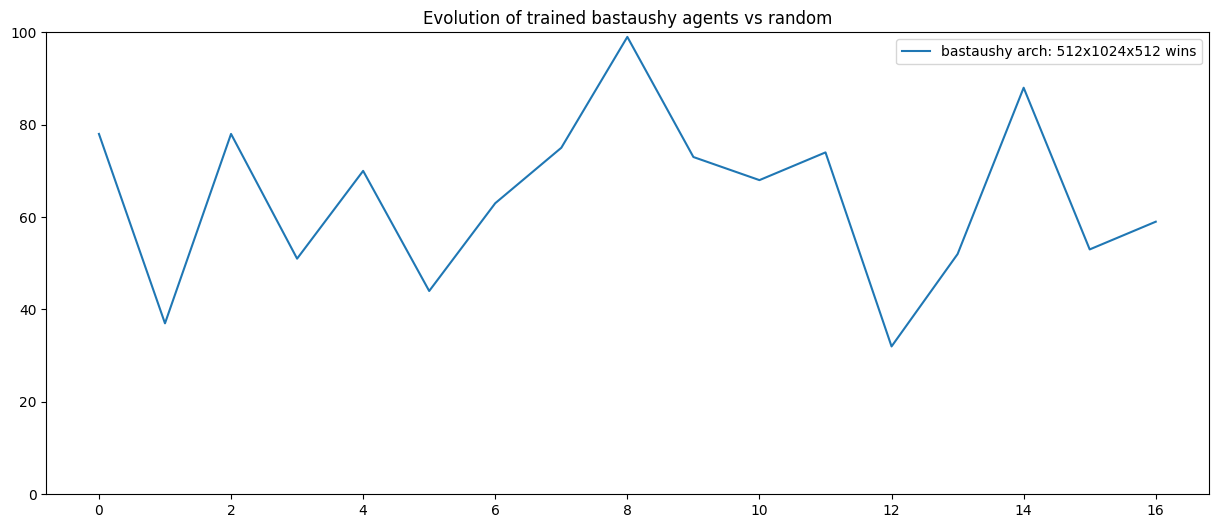

In [100]:
plt.figure(figsize=(15,6))
NUM_MODELS = 15

for arch in NET_ARCHS:
    
    #if arch in :
    
        arch_name = arch2str(arch)

        # cubic_interpolation_model = interp1d(range(len(bastaushy_vs_random_wins[arch_name])), bastaushy_vs_random_wins[arch_name], kind = "cubic", fill_value="extrapolate")
         
        # # Plotting the Graph
        # if arch in selected_archs:
        #     X_= np.linspace(0, NUM_MODELS, NUM_MODELS - 1)
        #     Y_= cubic_interpolation_model(X_)
        # else:
        #     X_= np.linspace(0, 7, 10)
        #     Y_= cubic_interpolation_model(X_)
        plt.plot(range(len(bastaushy_vs_random_wins[arch_name])), bastaushy_vs_random_wins[arch_name], label=f'bastaushy arch: {arch_name} wins')
        
plt.legend()
plt.title("Evolution of trained bastaushy agents vs random")
plt.ylim(0, 100)
plt.show()

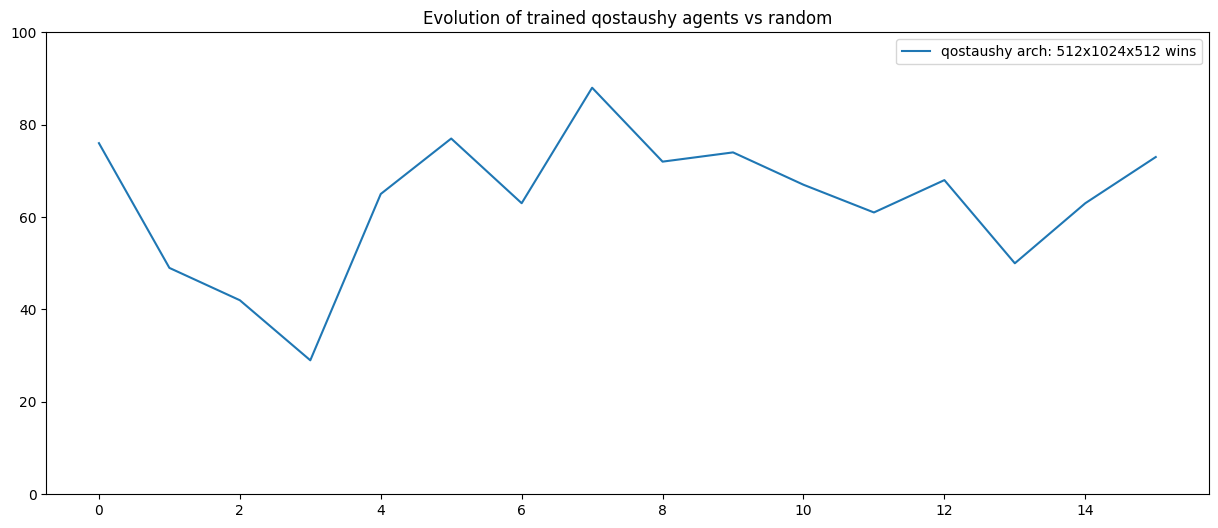

In [104]:
plt.figure(figsize=(15,6))

for arch in NET_ARCHS:
    
        arch_name = arch2str(arch)
        
        # cubic_interpolation_model = interp1d(range(len(qostaushy_vs_random_wins[arch_name])), qostaushy_vs_random_wins[arch_name], kind = "cubic")
         
        # # Plotting the Graph
        # if arch in selected_archs:
        #     X_= np.linspace(0, NUM_MODELS, NUM_MODELS - 1)
        #     Y_= cubic_interpolation_model(X_)
        # else:
        #     X_= np.linspace(0, 7, 10)
        #     Y_= cubic_interpolation_model(X_)
        
        plt.plot(range(len(qostaushy_vs_random_wins[arch_name])), qostaushy_vs_random_wins[arch_name], label=f'qostaushy arch: {arch_name} wins')
        
plt.legend()
plt.title("Evolution of trained qostaushy agents vs random")
plt.ylim(0, 100)
plt.show()

### 🐦 Play all trained policies

In [57]:
bastaushy_wins = {arch2str(key): [] for key in NET_ARCHS}

game_rewards = {arch2str(key): {} for key in NET_ARCHS}

for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)

    game_rewards[arch_name] = {}

    for i in range(len(agents_learned_bastaushy[arch_name])):
        
        for j in range(len(agents_learned_qostaushy[arch_name])):
        
            game_rewards[arch_name][f'{i}vs{j}'] = []

    loc_plays_lst = []

    for n_agent, agent in tqdm(enumerate(agents_learned_bastaushy[arch_name])):

        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        full_opp_qostaushy = []
        
        for arch_loc in NET_ARCHS:
            
            full_opp_qostaushy += agents_learned_qostaushy[arch2str(arch_loc)] 

        for n_agent_opp, agent_opponent in enumerate(full_opp_qostaushy):

            REWARDS = {"bastaushy": [], "qostaushy": []}
            
            env = _get_env()#render_mode='human')
            
            # env.reset()

            policies = MultiAgentPolicyManager(policies=[agent, agent_opponent], env=env)
            
            test_envs = DummyVectorEnv([lambda: env for _ in range(10)])

            collector = Collector(policies, test_envs, exploration_noise=False)

            result = collector.collect(n_episode=1, reset_before_collect=True)

            game_rewards[arch_name][f'{n_agent}vs{n_agent_opp}'].append(REWARDS)
        # print(f"Bastaushy arch {arch_name} #{n_agent} wins {PLAYS["bastaushy"]} times")
            
        bastaushy_wins[arch_name].append(PLAYS["bastaushy"])

0it [00:00, ?it/s]

In [58]:
bastaushy_wins['512x1024x512']

[0, 1, 1]

{'512x1024x512': [8, 5, 4, 7, 2, 7, 8, 7, 4, 8, 5]}

In [55]:
qostaushy_wins = {arch2str(key): [] for key in NET_ARCHS}

for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)
    
    for n_agent, agent in tqdm(enumerate(agents_learned_qostaushy[arch_name])):

        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        full_opp_bastaushy = []
        
        for arch_loc in NET_ARCHS:
            
            full_opp_bastaushy += agents_learned_bastaushy[arch2str(arch_loc)] 

        for n_agent_opp, agent_opponent in enumerate(full_opp_bastaushy):
            
            env = _get_env()#render_mode='human')

            policies = MultiAgentPolicyManager(policies=[agent_opponent, agent], env=env)
            
            test_envs = DummyVectorEnv([lambda: env for _ in range(10)])

            collector = Collector(policies, test_envs, exploration_noise=False)

            result = collector.collect(n_episode=1, reset_before_collect=True)

        # print(f"Bastaushy arch {arch_name} #{n_agent} wins {PLAYS["bastaushy"]} times")        
        qostaushy_wins[arch_name].append(PLAYS["qostaushy"])

0it [00:00, ?it/s]

In [56]:
qostaushy_wins['512x1024x512']

[3, 2, 2]

{'512x1024x512': [6, 5, 3, 4, 7, 4, 7, 5, 6, 3, 6]}

### 🦑 Save data to files

In [ ]:
for arch in tqdm(NET_ARCHS):
    if arch not in selected_archs:
        for _ in range(9, NUM_MODELS + 1):
            bastaushy_wins[arch_name].append(0)
            qostaushy_wins[arch_name].append(0)

In [36]:
with open("../data/bastaushy_vs_others.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(bastaushy_wins.keys())

    writer.writerows(zip(*bastaushy_wins.values()))

In [37]:
with open("../data/qostaushy_vs_others.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(qostaushy_wins.keys())

    writer.writerows(zip(*qostaushy_wins.values()))

### 🦚 Read data

In [35]:
df_vs_others_basta = pd.read_csv("../data/bastaushy_vs_others.csv")
df_vs_others_qosta = pd.read_csv("../data/qostaushy_vs_others.csv")

len(df_vs_others_basta['64x128x64'].values)

8

In [36]:
vs_others_basta = df_vs_others_basta.to_dict()

bastaushy_wins = {key: [] for key in vs_others_basta.keys()}

for key in vs_others_basta.keys():
    bastaushy_wins[key] = list(vs_others_basta[key].values())

In [37]:
vs_others_qosta = df_vs_others_qosta.to_dict()

qostaushy_wins = {key: [] for key in vs_others_qosta.keys()}

for key in vs_others_qosta.keys():
    qostaushy_wins[key] = list(vs_others_qosta[key].values())

### 🐈 Plot play results

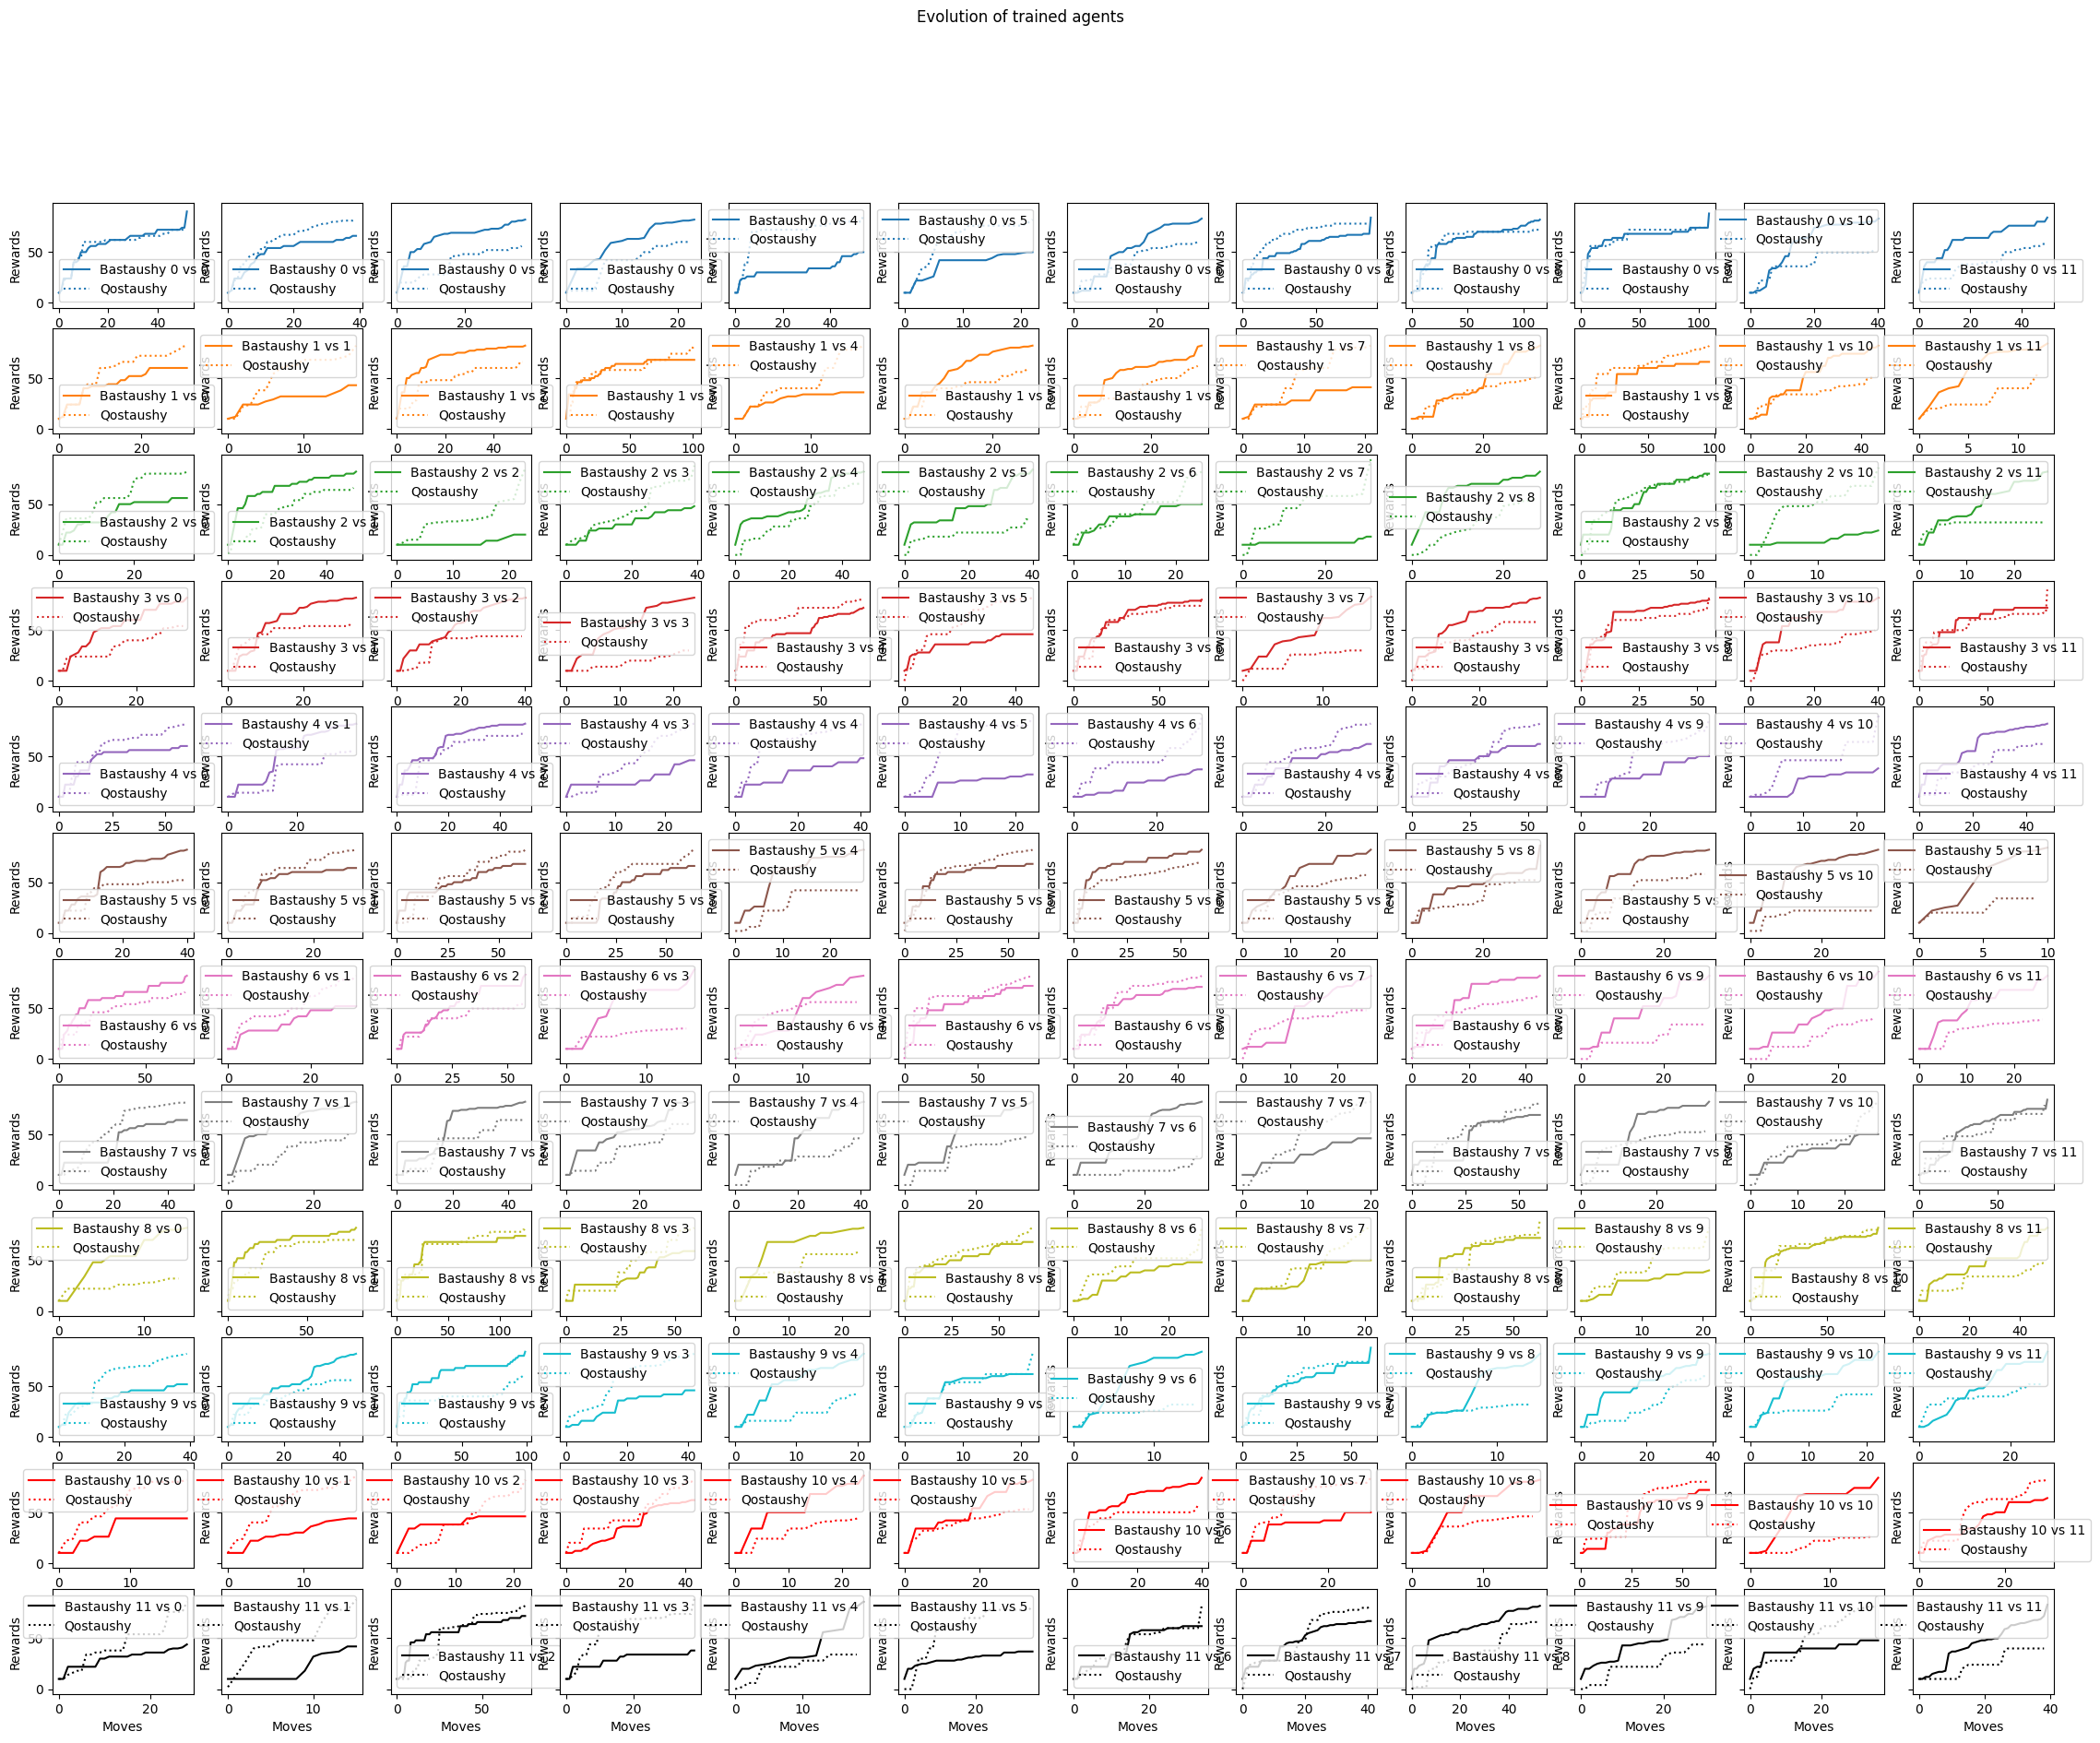

In [208]:
import matplotlib.colors as mcolors


list_colors = list(mcolors.TABLEAU_COLORS.keys()) + ['red', 'black']

num_models = 12

fig, axes = plt.subplots(num_models, num_models, figsize=(28, 21), sharey=True)

fig.suptitle("Evolution of trained agents")
for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)

    for i in range(num_models):
        j = 0
        for key in game_rewards[arch_name].keys(): 
            if j == num_models:
                j = j % num_models
            
            if key.split('vs')[0] == str(i):
                x_basta = range(len(game_rewards[arch_name][key][0]['bastaushy']))
                axes[i][j].plot(x_basta, game_rewards[arch_name][key][0]['bastaushy'], color=list_colors[i], label=f'Bastaushy {i} vs {j}')
                x_qosta = range(len(game_rewards[arch_name][key][0]['qostaushy']))
                axes[i][j].plot(x_qosta, game_rewards[arch_name][key][0]['qostaushy'], color=list_colors[i], linestyle='dotted', label=f'Qostaushy')
                axes[i][j].set(xlabel="Moves", ylabel="Rewards")
                axes[i][j].legend()
                j += 1

plt.show()

In [59]:
for i in range(3):
    print('=========================')
    print('i =', i)
    total_win_steps = 0
    wins = 0
    for j in range(3):

        print(game_rewards['512x1024x512'][f'{i}vs{j}'][0]['bastaushy'][-1], game_rewards['512x1024x512'][f'{i}vs{j}'][0]['qostaushy'][-1])
        print('num_moves =', len(game_rewards['512x1024x512'][f'{i}vs{j}'][0]['bastaushy']))
        if game_rewards['512x1024x512'][f'{i}vs{j}'][0]['bastaushy'][-1] > 81:
            wins += 1
            total_win_steps += len(game_rewards['512x1024x512'][f'{i}vs{j}'][0]['bastaushy'])
    print('wins =', wins)
    print('total_win_steps =', total_win_steps)

i = 0
56 106
num_moves = 71
54 108
num_moves = 68
66 96
num_moves = 65
wins = 0
total_win_steps = 0
i = 1
72 90
num_moves = 61
74 88
num_moves = 130
83 48
num_moves = 46
wins = 1
total_win_steps = 46
i = 2
28 84
num_moves = 99
82 64
num_moves = 202
64 82
num_moves = 118
wins = 1
total_win_steps = 202


In [60]:
for i in range(3):
    print('=========================')
    print('i =', i)
    total_win_steps = 0
    wins = 0
    for j in range(3):

        print(game_rewards['512x1024x512'][f'{j}vs{i}'][0]['bastaushy'][-1], game_rewards['512x1024x512'][f'{j}vs{i}'][0]['qostaushy'][-1])
        print('num_moves =', len(game_rewards['512x1024x512'][f'{j}vs{i}'][0]['qostaushy']))
        if game_rewards['512x1024x512'][f'{j}vs{i}'][0]['qostaushy'][-1] > 81:
            wins += 1
            total_win_steps += len(game_rewards['512x1024x512'][f'{j}vs{i}'][0]['qostaushy'])
    print('wins =', wins)
    print('total_win_steps =', total_win_steps)

i = 0
56 106
num_moves = 71
72 90
num_moves = 61
28 84
num_moves = 99
wins = 3
total_win_steps = 231
i = 1
54 108
num_moves = 68
74 88
num_moves = 130
82 64
num_moves = 201
wins = 2
total_win_steps = 198
i = 2
66 96
num_moves = 65
83 48
num_moves = 45
64 82
num_moves = 118
wins = 2
total_win_steps = 183


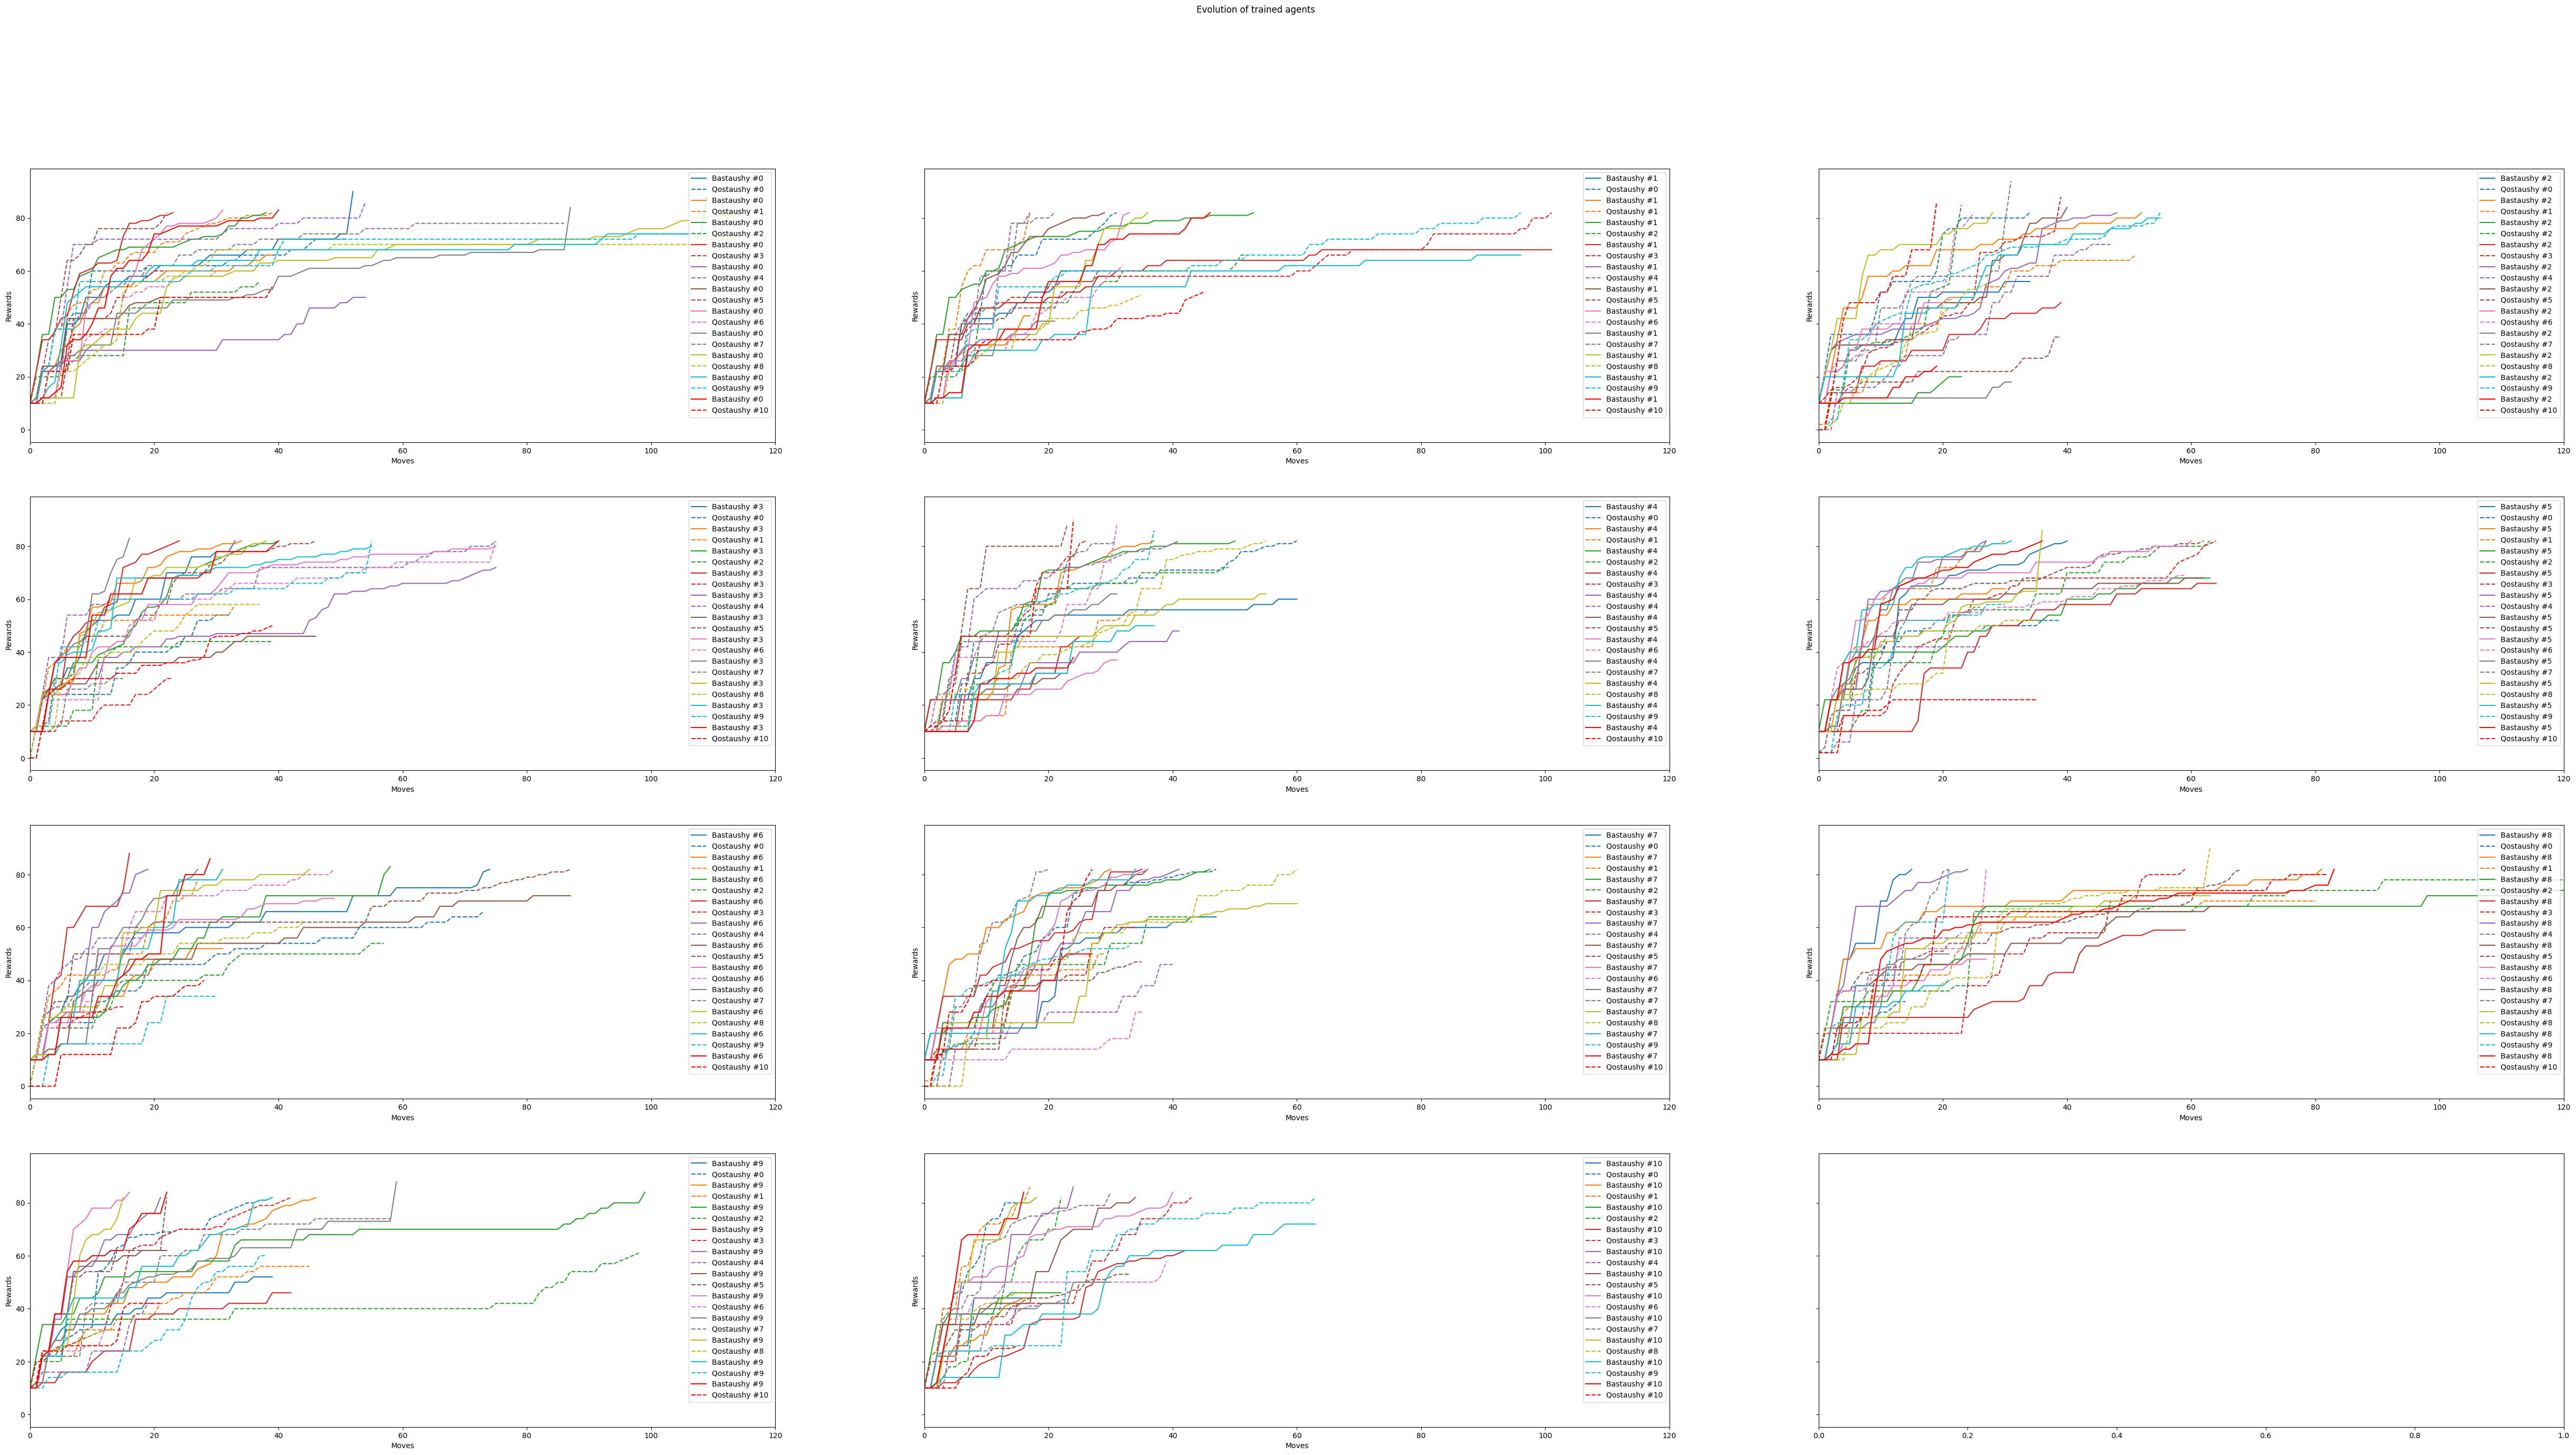

In [136]:
import math


num_models = 11

fig, axes = plt.subplots(4, 3, figsize=(62, 31), sharey=True)

fig.suptitle("Evolution of trained agents")

list_colors = list(mcolors.TABLEAU_COLORS.keys()) + ['red']

for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)

    vert = 0
    for i in range(num_models):
        j = 0
        for key in game_rewards[arch_name].keys(): 
            if j == num_models:
                j = j % num_models
                vert += 1
                vert = vert % 3
            n_agent = key.split('vs')[0]
            n_agent_opp = key.split('vs')[1]
            if n_agent == str(i):
                x_basta = range(len(game_rewards[arch_name][key][0]['bastaushy']))
                horiz = math.floor(i/3)
                axes[horiz][vert].plot(x_basta, game_rewards[arch_name][key][0]['bastaushy'], color=list_colors[j], label=f'Bastaushy #{n_agent}')
                x_qosta = range(len(game_rewards[arch_name][key][0]['qostaushy']))
                axes[horiz][vert].plot(x_qosta, game_rewards[arch_name][key][0]['qostaushy'], color=list_colors[j], linestyle='dashed', label=f'Qostaushy #{n_agent_opp}')
                axes[horiz][vert].set(xlabel="Moves", ylabel="Rewards")
                axes[horiz][vert].legend()
                axes[horiz][vert].set_xlim([0, 120])
                j += 1
plt.show()

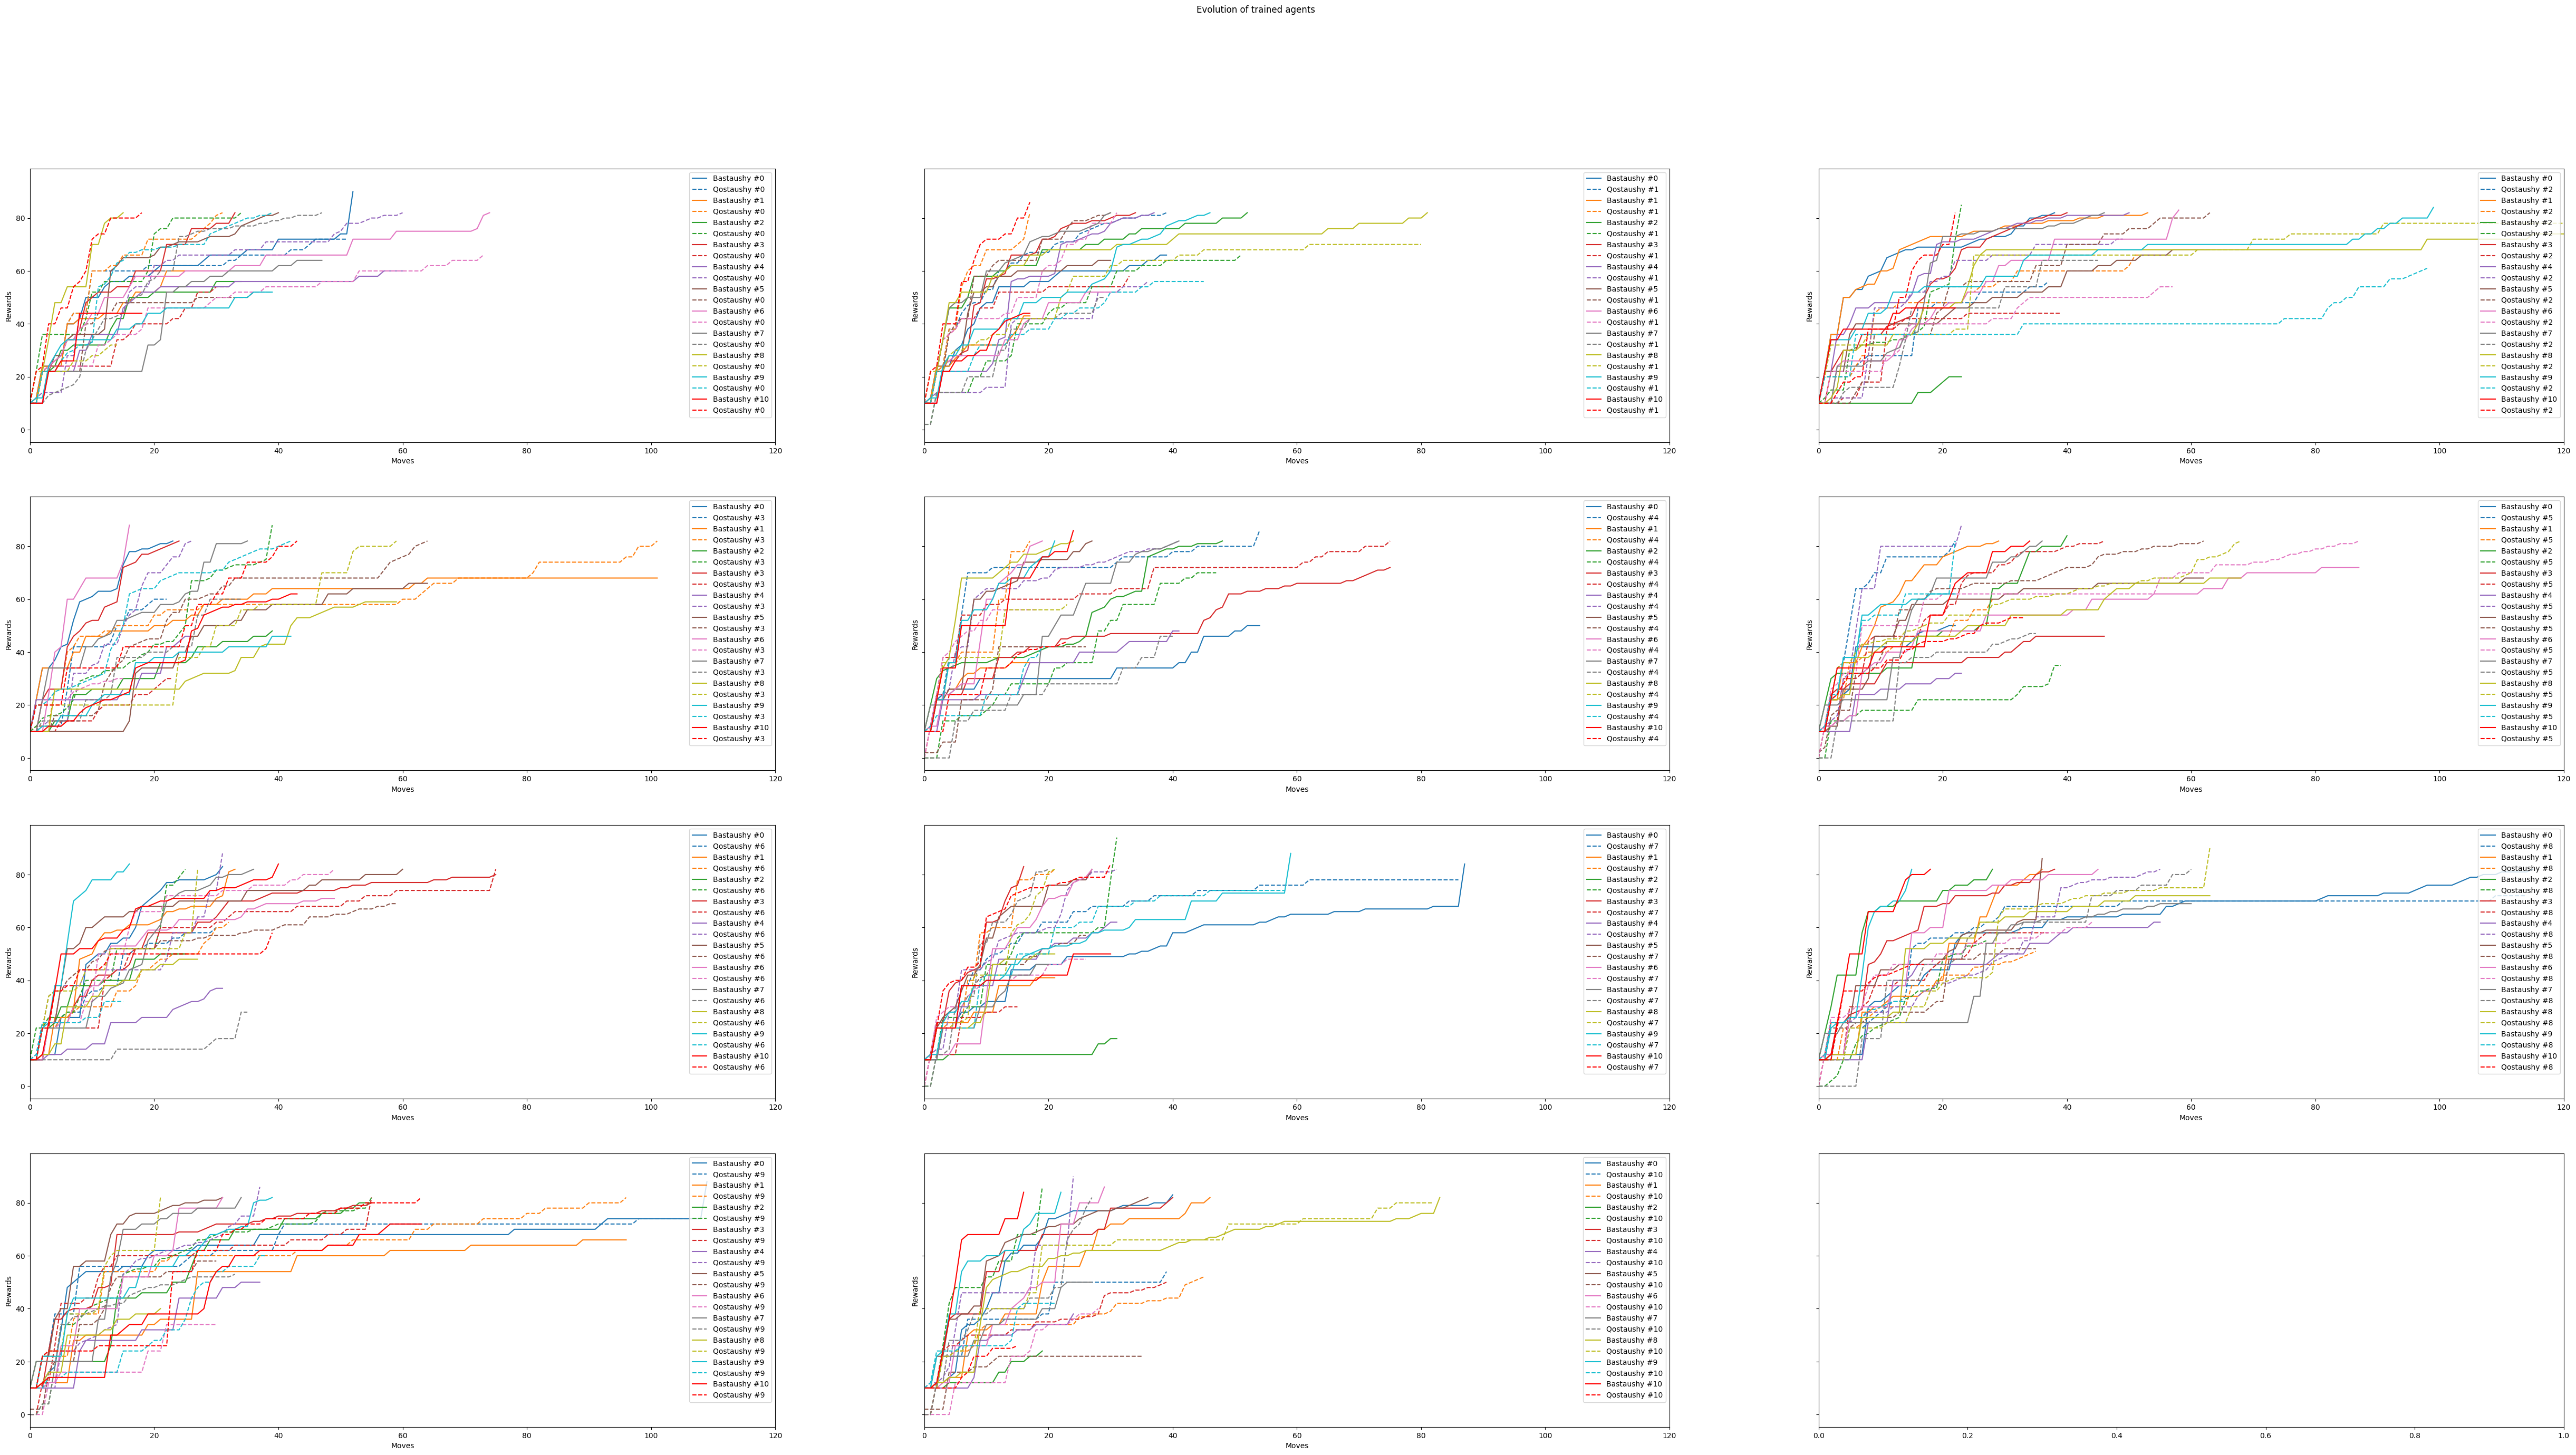

In [139]:
import math


num_models = 11

fig, axes = plt.subplots(4, 3, figsize=(62, 31), sharey=True)

fig.suptitle("Evolution of trained agents")

list_colors = list(mcolors.TABLEAU_COLORS.keys()) + ['red']

for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)

    vert = 0
    for i in range(num_models):
        j = 0
        for key in game_rewards[arch_name].keys(): 
            if j == num_models:
                j = j % num_models
                vert += 1
                vert = vert % 3
            n_agent = key.split('vs')[1]
            n_agent_opp = key.split('vs')[0]
            if n_agent == str(i):
                x_basta = range(len(game_rewards[arch_name][key][0]['bastaushy']))
                horiz = math.floor(i/3)
                axes[horiz][vert].plot(x_basta, game_rewards[arch_name][key][0]['bastaushy'], color=list_colors[j], label=f'Bastaushy #{n_agent_opp}')
                x_qosta = range(len(game_rewards[arch_name][key][0]['qostaushy']))
                axes[horiz][vert].plot(x_qosta, game_rewards[arch_name][key][0]['qostaushy'], color=list_colors[j], linestyle='dashed', label=f'Qostaushy #{n_agent}')
                axes[horiz][vert].set(xlabel="Moves", ylabel="Rewards")
                axes[horiz][vert].legend()
                axes[horiz][vert].set_xlim([0, 120])
                j += 1
plt.show()